# Plotting Windbarbs

This notebook will demonstrate how to plot Windbarb data from the GFS model using the basic matplotlib library. The data is coming from GFS 0.25 model, later on we will try to use FIJI NWP model data.
For GFS 0.25 we will download the subset from this website:
https://nomads.ncep.noaa.gov/cgi-bin/filter_gfs_0p25.pl
<br>Level : "10 m above ground", "925 mb", "850 mb"
<br>Variable : "UGRD", "VGRD"

The data is in GRIB2 format, so we will use the xarray library to read the data and plot it using matplotlib.
First we need to import required libraries.

## Part 1 : Reading the Data

In this part, we will try to explore the way to read and access the data when there are different levels and multiple variables in the same file.

In [1]:
import xarray as xr

In [3]:
# Read the data
file_path = 'D:/Projects/fiji-training-2024/data/wind.f003'
ds = xr.open_dataset(file_path, engine='cfgrib')

In [4]:
ds

<xarray.Dataset>
Dimensions:            (isobaricInhPa: 2, latitude: 721, longitude: 1440)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
  * isobaricInhPa      (isobaricInhPa) float64 925.0 850.0
  * latitude           (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude          (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time         datetime64[ns] ...
    heightAboveGround  float64 ...
Data variables:
    u                  (isobaricInhPa, latitude, longitude) float32 ...
    v                  (isobaricInhPa, latitude, longitude) float32 ...
    u10                (latitude, longitude) float32 ...
    v10                (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-06-19T23:12 GRIB to CDM+CF via cfgrib-0.9.1...

See that the data has 7 coordinates and 4 variables. In GFS, the 10 m wind and pressure level wind are stored in different variable. First let's try to access the 10 m wind data.

In [5]:
u10 = ds['u10']
v10 = ds['v10']

In [6]:
u10

<xarray.DataArray 'u10' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
  * latitude           (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude          (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time         datetime64[ns] ...
    heightAboveGround  float64 ...
Attributes: (12/29)
    GRIB_paramId:                             165
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre U wind component
    GRIB_shortName:                           10u
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            eastward_wind

In [43]:
# Slice it to Fiji region
u10 = u10.sel(latitude=slice(-5,-35), longitude=slice(165,205))
v10 = v10.sel(latitude=slice(-5,-35), longitude=slice(165,205))

The 10 meter wind have "heightAboveGround" as a coordinate. We can access the data using this coordinate as well. Now let's read the pressure level wind data.

In [10]:
# first see the available pressure levels
ds.isobaricInhPa

<xarray.DataArray 'isobaricInhPa' (isobaricInhPa: 2)>
array([925., 850.])
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
  * isobaricInhPa      (isobaricInhPa) float64 925.0 850.0
    valid_time         datetime64[ns] ...
    heightAboveGround  float64 ...
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure

In [11]:
# assign a variable and select the level
u925 = ds['u'].sel(isobaricInhPa=925)

### Exercise:
1. Read all the rest and assign it to a variable corresponding to their level and variable. (v925, u850, v850)
2. Slice it to Fiji region, you can add argument to the sel function to slice the data. For example, sel(lat=slice(-20, -25), lon=slice(175, 180))

In [12]:
v925 = ds['v'].sel(isobaricInhPa=925)
u850 = ds['u'].sel(isobaricInhPa=850)
v850 = ds['v'].sel(isobaricInhPa=850)

## Part 2 : Calculating Wind Speed and Direction

The wind data is stored in U and V component. We need to calculate the wind speed and direction from these components to be used later in plotting the windbarbs. The unit of the wind component is m/s, if you want to have it in another unit you can convert it, for example to knot.

In [13]:
import numpy as np

In [44]:
# Converting to knot
u10_knot = u10 * 1.94384449
v10_knot = v10 * 1.94384449

In [45]:
# Calculate the wind speed
ws10 = np.sqrt(u10**2 + v10**2)

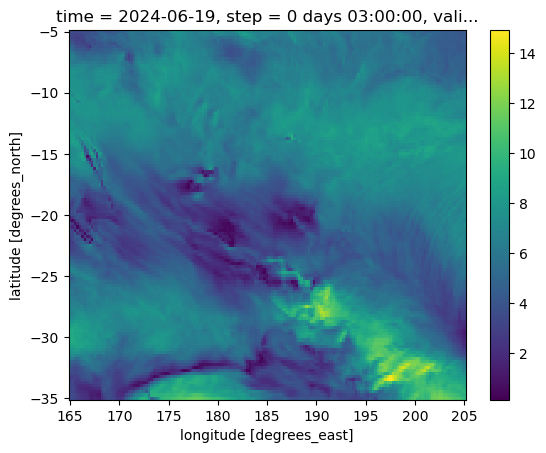

In [46]:
ws10.plot()

### Now it's your turn:
Convert the wind speed to knot and calculate the wind speed for the rest of the data. (ws925, ws850)

## Part 3 : Plotting Windbarbs
To plot windbarbs we are going to use matplotlib ax.barbs method.

In [75]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [32]:
# Create a meshgrid for latitude and longitude
lon, lat = np.meshgrid(u10.longitude, u10.latitude)

For plotting the windbarbs, we need to make meshgrid for the latitude and longitude. The meshgrid is used to make the windbarbs in the correct position.<br>
Here's why a meshgrid is necessary:

1. Consistent Grid Structure: The u10 and v10 wind components are provided on a grid defined by latitude and longitude coordinates. To plot these vectors correctly, we need to ensure that each point on the plot corresponds to the correct geographic location. A meshgrid helps in creating a 2D grid from the 1D arrays of latitude and longitude, making it easy to plot the data on a consistent and accurate grid structure.
2. Vector Plotting: Wind barbs and other vector plots (like quivers) require pairs of coordinates to plot vectors accurately. These coordinates are derived from the latitude and longitude values of the dataset. By creating a meshgrid, we generate all the possible coordinate pairs, which are necessary inputs for plotting functions like plt.barbs in matplotlib.
3. Alignment of Data: When dealing with meteorological data, the wind components (u and v) are typically given as 2D arrays corresponding to a grid of latitudes and longitudes. By using np.meshgrid, we ensure that these components are correctly aligned with their corresponding geographic coordinates. This alignment is crucial for accurate representation and visualization.

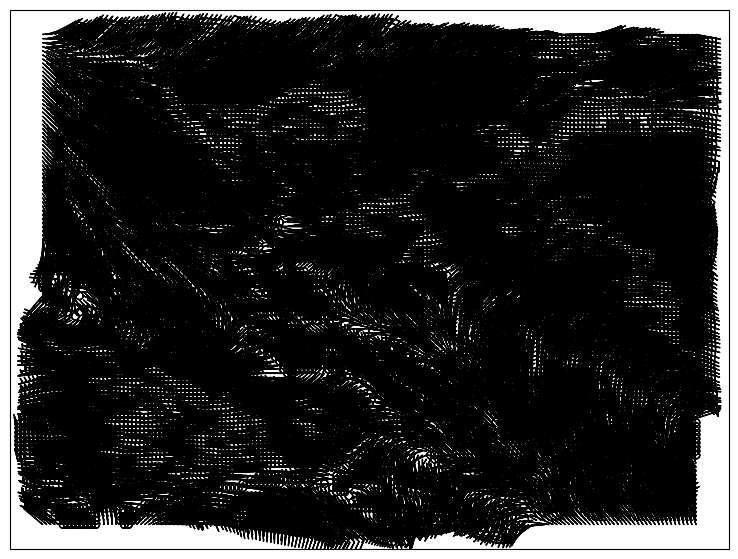

In [33]:
# Initiate figure and axes instance
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=185)})

# Plot wind barbs
ax.barbs(lon, lat, u10.values, v10.values, length=6, transform=ccrs.PlateCarree())

See that the barbs is too dense to even give information. We can subsample the data to make it more readable.

In [34]:
# Reduce the density of the data (e.g., every 5th point)
step = 5
u10_sub = u10[::step, ::step]
v10_sub = v10[::step, ::step]
ws10_sub = ws10[::step, ::step]
lon_sub = u10.longitude[::step]
lat_sub = u10.latitude[::step]

In [35]:
# Create a meshgrid for subsampled latitude and longitude
lon_sub, lat_sub = np.meshgrid(lon_sub, lat_sub)

Replot it again using subsampled data

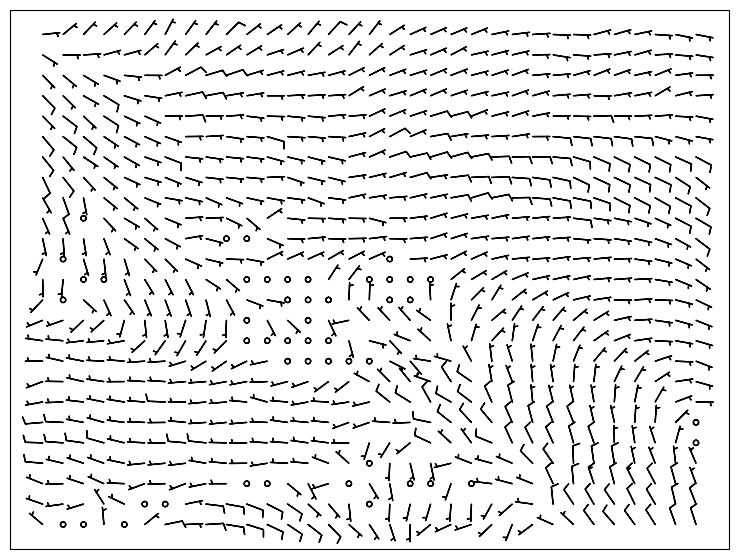

In [37]:
# Initiate figure and axes instance
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=185)})

# Plot wind barbs
ax.barbs(lon_sub, lat_sub, u10_sub.values, v10_sub.values, length=5, transform=ccrs.PlateCarree())

See that the barb flag still pointing right, while for southern hemisphere, the barb flag should be pointing left. We need to flip the flag by creating an Boolean array which contain False if the grid is in northern hemisphere and True if it's in southern hemisphere.

In [39]:
flip_barbs = lat_sub < 0
flip_barbs

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  T

Now let's plot it again, and pass the flip_barbs as an argument to the barbs method.

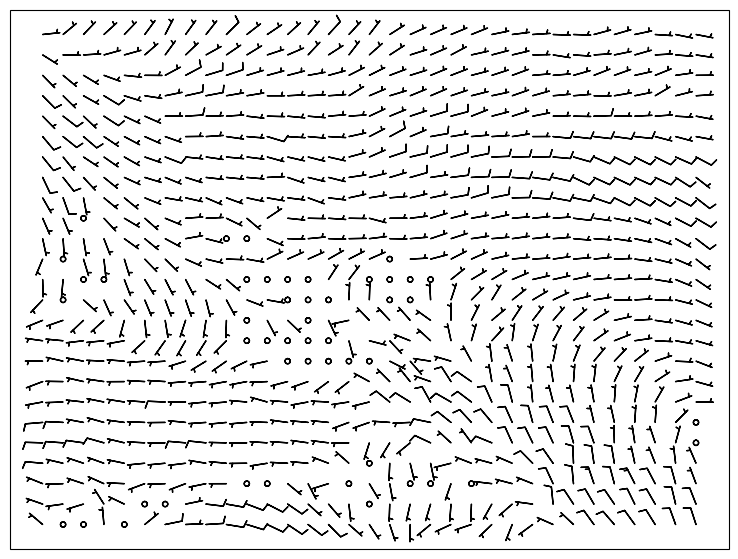

In [49]:
# Initiate figure and axes instance
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=185)})

# Plot wind barbs
ax.barbs(lon_sub, lat_sub, u10_sub.values, v10_sub.values, length=5, flip_barb= flip_barbs,transform=ccrs.PlateCarree())

Let's add windspeed in shaded plot, we will preserve the original resolution for the wind speed.

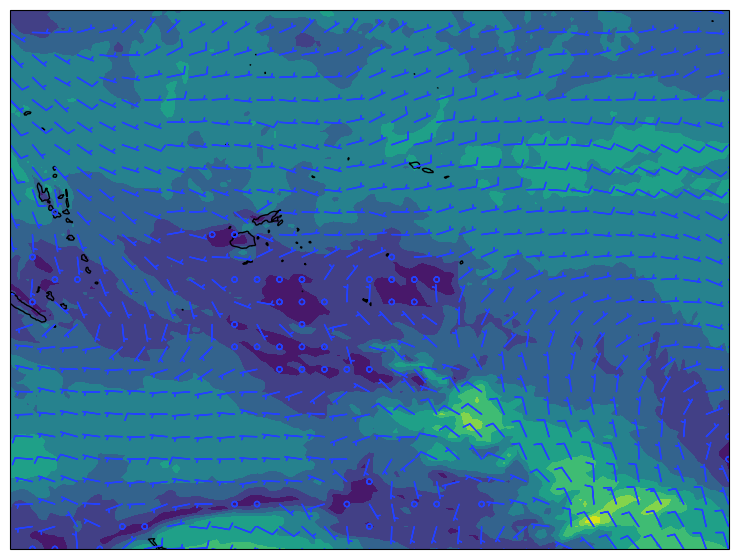

In [80]:
# Initiate figure and axes instance
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=185)})

# Plot wind barbs
ax.barbs(lon_sub, lat_sub, u10_sub.values, v10_sub.values, length=5, barbcolor='#2341ff', flip_barb= flip_barbs,transform=ccrs.PlateCarree(), zorder=2)

# Plot wind speed in shaded plot
ax.contourf(lon,lat, ws10, transform=ccrs.PlateCarree(), zorder=1)

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

### Now it's your turn:
1. Plot the windbarbs for the rest of the data (u925, v925, u850, v850)

## Part 4 : Customize the Plot

### 4.1 Customizing color and add colorbar

We will define the color based on what used in BMKG plot.<br>
To modify the colormap for the contour, we will use the matplotlib colors module. We will also add a colorbar to the plot to show the wind speed values.

In [55]:
import matplotlib.colors as mcolors

In [56]:
# Define the color list and levels for the contour plot
colorlist = ["#eff8fd", "#ccf0fe", "#9cdbfc", "#acffa7", "#7ede78", "#e6e675", "#fecb00", "#ff7d4b", "#e5270d", "#be0000", "#990000", "#7f00a0", "#ff647f"]
levels = [0, 5, 10, 15, 20, 25, 34, 48, 64, 80, 100, 120]

In [57]:
# Create a custom colormap and normalization
cmap = mcolors.LinearSegmentedColormap.from_list("", colorlist)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, extend='both')
cmap.set_over(colorlist[-1])
cmap.set_under(colorlist[0])

For the colorbar, we will make it positioned relative to the plot axes. Hence, we need to get the axes position first and set the colorbar axes position relative to it. We will also do the same thing for the colorbar text, by getting the colorbar position and set the text position relative to it.

In [65]:
# add colorbar
pos = ax.get_position() # get the original position
cbaxes = fig.add_axes([pos.x0, pos.y0 - 0.025, pos.x1 - pos.x0, 0.02])  # colorbar axes position left,bottom,width,height
plt.colorbar(plot, cax=cbaxes, orientation='horizontal', ticks=levels, extend="both", cmap=cmap)
cbaxes.tick_params(labelsize=8)

<Figure size 640x480 with 0 Axes>

In [66]:
# add colorbar text
cbar_text = 'Wind Speed (knot)'
cbpos = cbaxes.get_position()
ax.text(x=0.5, y=cbpos.y0 - 0.04, s=cbar_text, size=10, ha="center", transform=fig.transFigure)

Text(0.5, 0.04499999999999999, 'Wind Speed (knot)')

### 4.2 Add Title and Text Information
We will do the same approach to add title and text information to the plot. We will get the axes position and set the text position relative to it. A little bit different from what we did in the MSLP plot.

In [62]:
title_text = 'Wind Speed and Direction at 10 m above ground'
time_text = 'Valid at 2024-06-18 03.00 UTC'
ax.set_title(title_text, x=pos.x0, y=pos.y1 + 0.074, pad=25, fontsize=14,ha="left", transform=fig.transFigure)
ax.text(x=pos.x0, y=pos.y1 + 0.04, s=time_text,transform=fig.transFigure, size=12, ha="left")

<Figure size 640x480 with 0 Axes>

### 4.3 Add Logo

In [73]:
pos = ax.get_position()
lgaxes = fig.add_axes([pos.x1 - 0.06, pos.y1 + 0.03, 0.06, 0.06], )  # l,b,w,h
lgaxes.imshow(plt.imread("D:/Projects/fiji-training-2024/data/Coat_of_arms_of_Fiji.png"))
lgaxes.axis("off")

(-0.5, 454.5, 448.5, -0.5)

### 4.4 Add gridlines
We will do the same as MSLP

In [81]:
from matplotlib.ticker import FixedLocator # to set the lat lon values needed to plot

In [84]:
# Draw gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.bottom_labels = False
gl.top_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'gray'}
gl.ylabel_style = {'size': 5, 'color': 'gray'}

# Set specific values for the gridlines
gl.xlocator = FixedLocator([165, 170, 175, 180, -175, -170, -165, -160, -155])
gl.ylocator = FixedLocator([-35, -30, -25, -20, -15, -10, -5])

## Your Turn
1. Add the customization to the rest of the plot (u925, v925, u850, v850)

## Complete Script

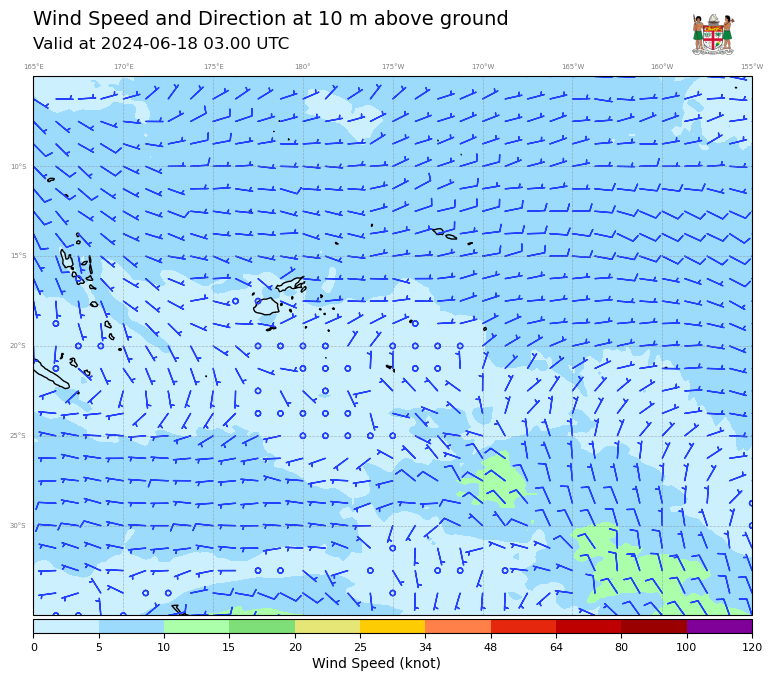

In [91]:
# Initiate figure and axes instance
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=185)})

# Plot wind barbs
ax.barbs(lon_sub, lat_sub, u10_sub.values, v10_sub.values, length=5, barbcolor='#2341ff', flip_barb= flip_barbs,transform=ccrs.PlateCarree(), zorder=2)

# Plot wind speed in shaded plot
plot = ax.contourf(lon,lat, ws10, levels=levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), zorder=1)

# add colorbar
pos = ax.get_position() # get the original position
cbaxes = fig.add_axes([pos.x0, pos.y0 - 0.025, pos.x1 - pos.x0, 0.02])  # colorbar axes position left,bottom,width,height
plt.colorbar(plot, cax=cbaxes, orientation='horizontal', ticks=levels, extend="both", cmap=cmap)
cbaxes.tick_params(labelsize=8)

# add colorbar text
cbar_text = 'Wind Speed (knot)'
cbpos = cbaxes.get_position()
ax.text(x=0.5, y=cbpos.y0 - 0.05, s=cbar_text, size=10, ha="center", transform=fig.transFigure)

title_text = 'Wind Speed and Direction at 10 m above ground'
time_text = 'Valid at 2024-06-18 03.00 UTC'
ax.set_title(title_text, x=pos.x0, y=pos.y1 + 0.074, pad=25, fontsize=14,ha="left", transform=fig.transFigure)
ax.text(x=pos.x0, y=pos.y1 + 0.04, s=time_text,transform=fig.transFigure, size=12, ha="left")

pos = ax.get_position()
lgaxes = fig.add_axes([pos.x1 - 0.06, pos.y1 + 0.03, 0.06, 0.06], )  # l,b,w,h
lgaxes.imshow(plt.imread("D:/Projects/fiji-training-2024/data/Coat_of_arms_of_Fiji.png"))
lgaxes.axis("off")

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Draw gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.bottom_labels = False
gl.top_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'gray'}
gl.ylabel_style = {'size': 5, 'color': 'gray'}

# Set specific values for the gridlines
gl.xlocator = FixedLocator([165, 170, 175, 180, -175, -170, -165, -160, -155])
gl.ylocator = FixedLocator([-35, -30, -25, -20, -15, -10, -5])